In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn import metrics

import pydotplus
from sklearn import tree
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [176]:
match = pd.read_csv('match.csv')
players = pd.read_csv('players.csv')

In [177]:
match.head()

match_id  start_time  duration  tower_status_radiant  tower_status_dire  \
0         0  1446750112      2375                  1982                  4   
1         1  1446753078      2582                     0               1846   
2         2  1446764586      2716                   256               1972   
3         3  1446765723      3085                     4               1924   
4         4  1446796385      1887                  2047                  0   

   barracks_status_dire  barracks_status_radiant  first_blood_time  game_mode  \
0                     3                       63                 1         22   
1                    63                        0               221         22   
2                    63                       48               190         22   
3                    51                        3                40         22   
4                     0                       63                58         22   

  radiant_win  negative_votes  positive_votes  cluster  
0        True               0               1      155  
1       False               0               2      154  
2       False               0               0      132  
3       False               0               0      191  
4        True               0               0      156

In [178]:
def team_assign(x):
    if x < 100:
        y = 0
    else:
        y = 1
    return y

In [179]:
players['team'] = players['player_slot'].apply(team_assign)

In [180]:
players.columns

Index(['match_id', 'account_id', 'hero_id', 'player_slot', 'gold',
       'gold_spent', 'gold_per_min', 'xp_per_min', 'kills', 'deaths',
       'assists', 'denies', 'last_hits', 'stuns', 'hero_damage',
       'hero_healing', 'tower_damage', 'item_0', 'item_1', 'item_2', 'item_3',
       'item_4', 'item_5', 'level', 'leaver_status', 'xp_hero', 'xp_creep',
       'xp_roshan', 'xp_other', 'gold_other', 'gold_death', 'gold_buyback',
       'gold_abandon', 'gold_sell', 'gold_destroying_structure',
       'gold_killing_heros', 'gold_killing_creeps', 'gold_killing_roshan',
       'gold_killing_couriers', 'unit_order_none',
       'unit_order_move_to_position', 'unit_order_move_to_target',
       'unit_order_attack_move', 'unit_order_attack_target',
       'unit_order_cast_position', 'unit_order_cast_target',
       'unit_order_cast_target_tree', 'unit_order_cast_no_target',
       'unit_order_cast_toggle', 'unit_order_hold_position',
       'unit_order_train_ability', 'unit_order_drop_item',


In [181]:
df = pd.DataFrame()

df['team_kills'] = players.groupby(['match_id','team'])['kills'].sum()

df['team_deaths'] = players.groupby(['match_id','team'])['deaths'].sum()

In [182]:
df = df.rename(columns={'deaths':'team_deaths'});

In [183]:
df = df.reset_index()

In [184]:
df.head()

match_id  team  team_kills  team_deaths
0         0     0          50           17
1         0     1          15           52
2         1     0          35           53
3         1     1          50           37
4         2     0          22           49

In [185]:
df1 = df.query('team == 0')

df1 = df1.rename(columns={'team_kills':'team_1_kills','team_deaths':'team_1_deaths'})

In [186]:
df1.head()

match_id  team  team_1_kills  team_1_deaths
0         0     0            50             17
2         1     0            35             53
4         2     0            22             49
6         3     0            64             66
8         4     0            37             16

In [187]:
df2 = df.query('team == 1')

df2 = df2.rename(columns={'team_kills':'team_2_kills','team_deaths':'team_2_deaths'})

df1.drop('team',axis=1,inplace=True)
df2.drop('team',axis=1,inplace=True)

In [188]:
second_pass = df1.merge(df2, how='outer',on='match_id')

In [189]:
second_pass.head()

match_id  team_1_kills  team_1_deaths  team_2_kills  team_2_deaths
0         0            50             17            15             52
1         1            35             53            50             37
2         2            22             49            48             22
3         3            64             66            63             65
4         4            37             16            16             37

In [190]:
second_pass['team_1_env_death'] = second_pass['team_1_deaths'] - second_pass['team_2_kills']

second_pass['team_2_env_death'] = second_pass['team_2_deaths'] - second_pass['team_1_kills']

In [191]:
second_pass.head()

match_id  team_1_kills  team_1_deaths  team_2_kills  team_2_deaths  \
0         0            50             17            15             52   
1         1            35             53            50             37   
2         2            22             49            48             22   
3         3            64             66            63             65   
4         4            37             16            16             37   

   team_1_env_death  team_2_env_death  
0                 2                 2  
1                 3                 2  
2                 1                 0  
3                 3                 1  
4                 0                 0

In [193]:
second_pass.drop(['team_1_deaths','team_2_deaths'],axis=1,inplace=True)

ValueError: labels ['team_1_deaths' 'team_2_deaths'] not contained in axis

In [194]:
second_pass.head()

match_id  team_1_kills  team_2_kills  team_1_env_death  team_2_env_death
0         0            50            15                 2                 2
1         1            35            50                 3                 2
2         2            22            48                 1                 0
3         3            64            63                 3                 1
4         4            37            16                 0                 0

In [195]:
second_pass['winner'] = match['radiant_win'].apply(lambda x: 1 if x == True else 0)

In [249]:
X.shape

(41047, 4)

In [196]:
X = second_pass.iloc[:,1:-1]
y = second_pass.iloc[:,-1]

In [247]:
xscaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xscaled,y,test_size=0.3, random_state=42)
rfc = RandomForestClassifier(max_depth=9)
rfc.fit(X_train,y_train)
rfc_acc = rfc.score(X_test,y_test)

In [248]:
print(rfc_acc)

0.901339829476


In [205]:
third_pass = second_pass

In [220]:
test = players[['match_id','leaver_status']]

In [222]:
blank = pd.DataFrame()

In [223]:
blank['match_id'] = second_pass['match_id']

In [224]:
blank['leaver_status'] = test.groupby(['match_id'])['leaver_status'].sum()

In [225]:
blank

match_id  leaver_status
0             0              0
1             1              0
2             2              0
3             3              0
4             4              0
5             5              0
6             6              0
7             7              1
8             8              0
9             9              0
10           10              0
11           11              0
12           12              0
13           13              0
14           14              0
15           15              0
16           16              0
17           17              0
18           18              0
19           19              1
20           20              0
21           21              0
22           22              1
23           23              0
24           24              0
25           25              0
26           26              0
27           27              0
28           28              0
29           29              0
...         ...            ...
49970     49970              0
49971     49971              0
49972     49972              0
49973     49973              0
49974     49974              0
49975     49975              4
49976     49976              0
49977     49977              0
49978     49978              0
49979     49979              0
49980     49980              0
49981     49981              0
49982     49982              0
49983     49983              0
49984     49984              0
49985     49985              0
49986     49986              0
49987     49987              0
49988     49988              0
49989     49989              0
49990     49990              0
49991     49991              0
49992     49992              2
49993     49993              0
49994     49994              0
49995     49995              0
49996     49996              0
49997     49997              0
49998     49998              0
49999     49999              0

[50000 rows x 2 columns]

In [226]:
blank = blank.query('leaver_status == 0')

In [227]:
blank.shape

(42220, 2)

In [228]:
third_pass= third_pass.merge(blank,on='match_id',how='inner')

In [229]:
third_pass

match_id  team_1_kills  team_2_kills  team_1_env_death  \
0             0            50            15                 2   
1             1            35            50                 3   
2             2            22            48                 1   
3             3            64            63                 3   
4             4            37            16                 0   
5             5            49            21                 2   
6             6            40            28                 1   
7             8            17            50                 1   
8             9            37            57                 1   
9            10            32            13                 0   
10           11            40            48                 1   
11           12            64            55                 1   
12           13            34            25                 0   
13           14            41            20                 1   
14           15            52            62                 3   
15           16            49            45                 4   
16           17            57            56                 1   
17           18            38            27                 0   
18           20            36            30                 0   
19           21            38            22                 3   
20           23            42            49                 1   
21           24            40            50                 0   
22           25            34            32                 0   
23           26            28             9                 0   
24           27            25            49                 2   
25           28            46            21                 3   
26           29            63            42                 0   
27           30            43            36                 2   
28           31            21            43                 2   
29           33            42            56                 3   
...         ...           ...           ...               ...   
42190     49967            63            34                 0   
42191     49968            61            44                 0   
42192     49970            48            32                 2   
42193     49971            47            10                 1   
42194     49972            42            39                 1   
42195     49973            45            33                 1   
42196     49974            28            41                 0   
42197     49976             7            27                 0   
42198     49977            49            38                 4   
42199     49978            37            22                 1   
42200     49979            32            44                 1   
42201     49980            36             7                 2   
42202     49981            44            47                 0   
42203     49982            32            37                 3   
42204     49983            42            22                 3   
42205     49984            54            24                 1   
42206     49985            26            45                 2   
42207     49986            52            44                 2   
42208     49987            55            50                 1   
42209     49988            29            41                 2   
42210     49989             7            41                 0   
42211     49990            51            33                 1   
42212     49991            58            48                 3   
42213     49993            34            56                 3   
42214     49994            37            62                 0   
42215     49995            43            45                 1   
42216     49996            38            16                 0   
42217     49997            54            31                 1   
42218     49998            28            19                 4   
42219     49999            30            4

In [230]:
third_pass.shape

(42220, 7)

In [231]:
df = match[['match_id','game_mode']]

In [232]:
df=df.query('game_mode==22')

In [233]:
third_pass = third_pass.merge(df, how='inner',on='match_id')

In [234]:
third_pass.shape

(41047, 8)

In [236]:
third_pass.head()

match_id  team_1_kills  team_2_kills  team_1_env_death  team_2_env_death  \
0         0            50            15                 2                 2   
1         1            35            50                 3                 2   
2         2            22            48                 1                 0   
3         3            64            63                 3                 1   
4         4            37            16                 0                 0   

   winner  leaver_status  game_mode  
0       1              0         22  
1       0              0         22  
2       0              0         22  
3       0              0         22  
4       1              0         22

In [242]:
y.shape

(41047,)

In [244]:
y.describe()

count    41047.000000
mean         0.519624
std          0.499621
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: winner, dtype: float64

In [237]:
X = third_pass.iloc[:,1:-3]
y = third_pass.iloc[:,-3]

In [239]:
xscaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xscaled,y,test_size=0.3, random_state=42)
rfc = RandomForestClassifier(max_depth=9)
rfc.fit(X_train,y_train)
rfc_acc = rfc.score(X_test,y_test)

In [240]:
print(rfc_acc)

0.901502233049


In [82]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_acc = lr.score(X_test,y_test)

In [83]:
print(lr_acc)

0.515483138781


In [227]:
max_depth_range = range(1,27,2)
param_grid = dict(max_depth=max_depth_range) 

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 27, 2)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [228]:
grid.best_params_

{'max_depth': 9}

In [229]:
num_neighbors = [x for x in range(1,21)]

accuracy = {}
for n in num_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy[n] = accuracy_score(y_test, y_pred)

In [230]:
for k,v in accuracy.items():
    print("For k=%s" % k + " the accuracy was " + str("%.2f" % round(v,4)))

For k=1 the accuracy was 0.87
For k=2 the accuracy was 0.87
For k=3 the accuracy was 0.88
For k=4 the accuracy was 0.89
For k=5 the accuracy was 0.89
For k=6 the accuracy was 0.89
For k=7 the accuracy was 0.89
For k=8 the accuracy was 0.89
For k=9 the accuracy was 0.90
For k=10 the accuracy was 0.90
For k=11 the accuracy was 0.90
For k=12 the accuracy was 0.90
For k=13 the accuracy was 0.90
For k=14 the accuracy was 0.90
For k=15 the accuracy was 0.90
For k=16 the accuracy was 0.90
For k=17 the accuracy was 0.90
For k=18 the accuracy was 0.90
For k=19 the accuracy was 0.90
For k=20 the accuracy was 0.90


In [171]:
accuracy

{1: 0.86499999999999999,
 2: 0.86819999999999997,
 3: 0.88526666666666665,
 4: 0.88486666666666669,
 5: 0.88980000000000004,
 6: 0.89000000000000001,
 7: 0.89239999999999997,
 8: 0.89133333333333331,
 9: 0.89606666666666668,
 10: 0.89539999999999997,
 11: 0.89753333333333329,
 12: 0.89813333333333334,
 13: 0.89939999999999998,
 14: 0.89939999999999998,
 15: 0.90059999999999996,
 16: 0.90073333333333339,
 17: 0.90006666666666668,
 18: 0.9012,
 19: 0.90173333333333339,
 20: 0.90126666666666666}

In [231]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ('\nConfusion Matrix:\n')
    print(conf)
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.90
Test Data Accuracy:     0.90


Precision:              0.90
Recall:                 0.89

Confusion Matrix:

[[4346  548]
 [ 462 4644]]


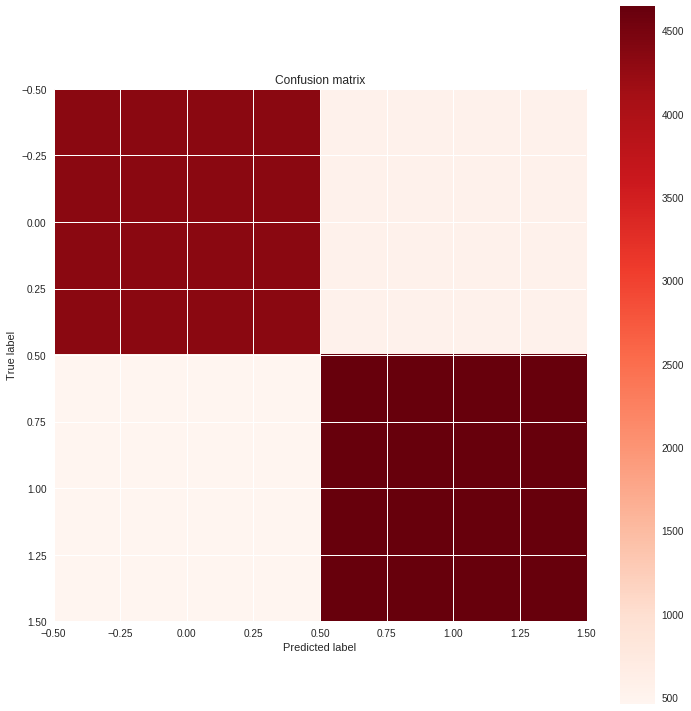

In [232]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

Training Data Accuracy: 0.90
Test Data Accuracy:     0.90


Precision:              0.89
Recall:                 0.89

Confusion Matrix:

[[4378  516]
 [ 517 4589]]


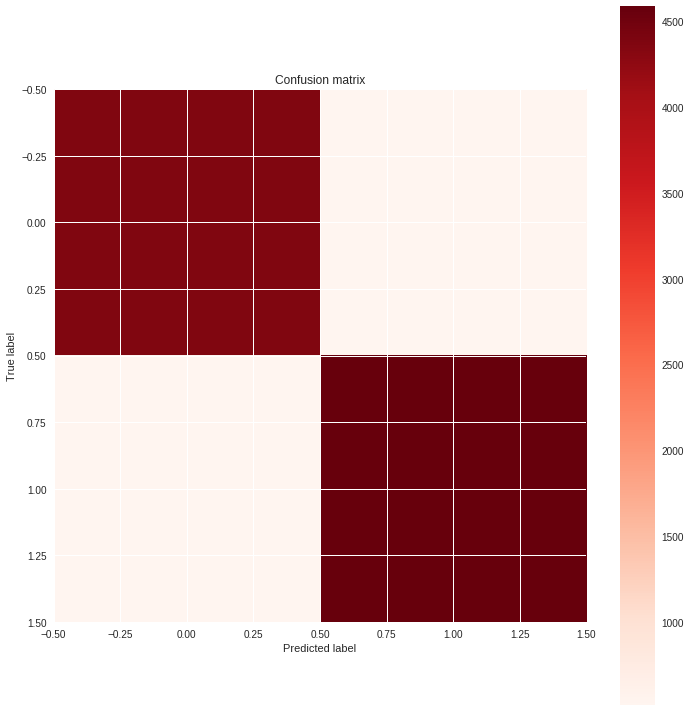

In [233]:
rfc_clf=RandomForestClassifier(max_depth=7)
train_score(rfc_clf,X,y)

In [234]:
rfc_clf.feature_importances_

array([ 0.43399675,  0.55634183,  0.00527042,  0.004391  ])

Training Data Accuracy: 0.91
Test Data Accuracy:     0.89


Precision:              0.89
Recall:                 0.90

Confusion Matrix:

[[4396  498]
 [ 562 4544]]


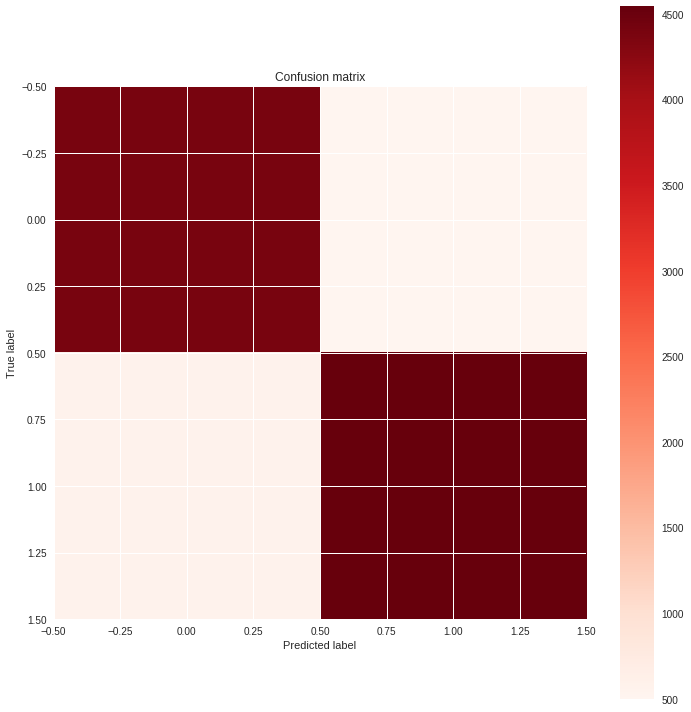

In [237]:
knn_clf=KNeighborsClassifier(n_neighbors=18)
train_score(knn_clf,X,y)

In [243]:
param_grid = dict(max_depth=[x for x in range(1,18)])

In [259]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=param_grid, cv=cv, scoring='f1')
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [260]:
grid.best_params_

{'max_depth': 8}

In [261]:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth=8)

In [265]:
dtc.fit(X,y);

Training Data Accuracy: 0.90
Test Data Accuracy:     0.89


Precision:              0.90
Recall:                 0.87

Confusion Matrix:

[[4277  617]
 [ 466 4640]]


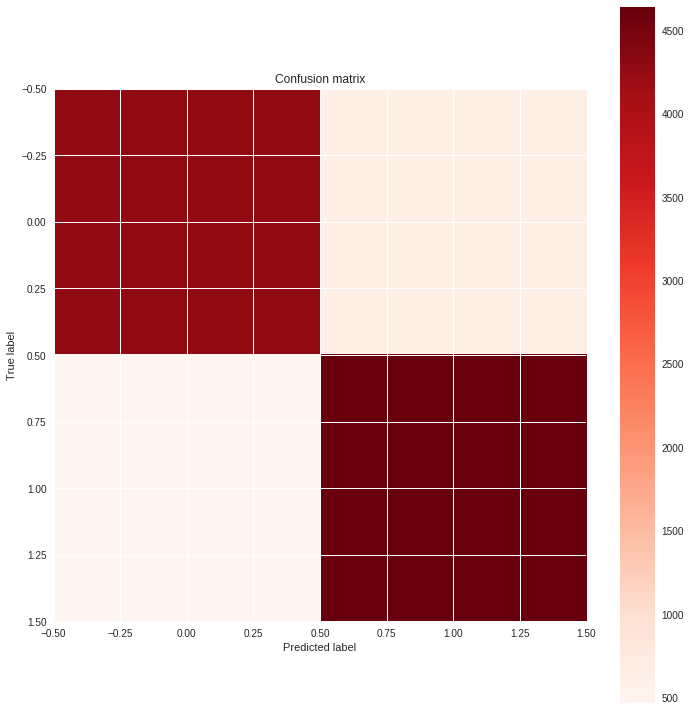

In [262]:
dtc_clf=DecisionTreeClassifier(criterion='entropy',max_depth=8)
train_score(dtc_clf,X,y)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.957232 to fit



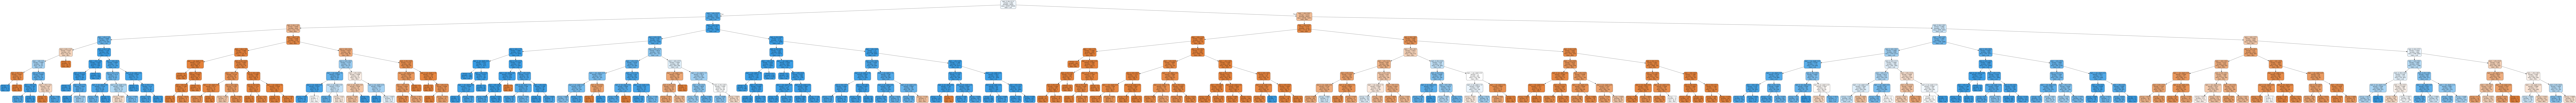

In [266]:
dot_data = tree.export_graphviz(dtc, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 

dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=X.columns,  
                         class_names=['Won','Lost'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())